In [60]:
import sys
sys.path.append("models/")

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import entropy
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from dataloader import SurveyDataset, load_demo, load_aggregate_travel_behavior, train_test_split
import mnl
from setup import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
variable_names = ['active','auto','mas','pt','trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


In [5]:
# target variables y

file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file)

train_test_index = df_pivot['train_test'].astype(bool)
y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index, :4]
y_test = y[train_test_index, :4]

In [63]:
# explanatory variables x

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

demo_cs, demo_np = load_demo(data_dir)
demo = np.hstack((np.array(demo_cs).reshape(-1,1), demo_np))
demo = pd.DataFrame(demo, columns = ['geoid'] + demo_variables)
demo_split = train_test_split(demo)

x_train = demo_split[~demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)
x_test = demo_split[demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)


# MNL for mode choice

In [ ]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=True)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [62]:
wd_list = [0.005, 0.01]
lr_list = [0.02, 0.04]

for (lr, wd) in itertools.product(lr_list, wd_list):
    # model setup
    model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # model training

    ref1 = 0
    ref2 = 0

    for epoch in range(400):

        kl_ = 0
        mse_ = 0
        mse1_ = 0
        mse2_ = 0
        mse3_ = 0
        mse4_ = 0

        for batch, (x_batch, y_batch) in enumerate(trainloader):
            # Compute prediction and loss
            util = model(x_batch)
            probs = torch.log(nn.functional.softmax(util, dim=1))
            kl = kldivloss(probs, y_batch)
    #         kl = kldivloss(torch.log(util), y_batch)
            kl_ += kl.item()

            mse = mseloss(torch.exp(probs), y_batch)
    #         mse = mseloss(util, y_batch)
            mse_ += mse.sum().item()
            mse1_ += mse[:,0].sum().item()
            mse2_ += mse[:,1].sum().item()
            mse3_ += mse[:,2].sum().item()
            mse4_ += mse[:,3].sum().item()
            mse = mse.sum()

            # Backpropagation
            optimizer.zero_grad()
            kl.backward()
            optimizer.step()

        train_kl = kl_/len(trainset)
        train_mse = np.sqrt(mse_/len(trainset))
        train_mse1 = np.sqrt(mse1_/len(trainset))
        train_mse2 = np.sqrt(mse2_/len(trainset))
        train_mse3 = np.sqrt(mse3_/len(trainset))
        train_mse4 = np.sqrt(mse4_/len(trainset))

        if epoch % 10 == 0:
            print(f"[epoch: {epoch:>2d}] Train KL loss: {train_kl:.3f} \
                RMSE {train_mse:.3f} \
                {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
        loss_ = train_kl

        if epoch % 5 == 0:
            if epoch > 50:
                if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                    print("Early stopping at epoch", epoch)
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_epoch = epoch
            else:
                best = loss_
                best_epoch = epoch

            ref2 = ref1
            ref1 = loss_

        if epoch % 10 == 0:

            kl_ = 0
            mse_ = 0 
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(testloader):
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util,dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()

            test_kl = kl_/len(testset)
            test_mse = np.sqrt(mse_/len(testset))
            test_mse1 = np.sqrt(mse1_/len(testset))
            test_mse2 = np.sqrt(mse2_/len(testset))
            test_mse3 = np.sqrt(mse3_/len(testset))
            test_mse4 = np.sqrt(mse4_/len(testset))

            r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
            r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
            r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
            r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

            print(f"[epoch: {epoch:>2d}] Test KL loss: {kl_/len(testset):.3f}\
                    RMSE {np.sqrt(mse_/len(testset)):.3f} \
                    {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
            print(f"\t\t\t\t\t\t\tR2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")


    with open(out_dir+"BA_mode_choice.csv", "a") as f:
        f.write("%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % 
                ("MNL",lr, wd,
                  train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                  r1, r2, r3, r4))

[epoch:  0] Train KL loss: 0.793                 RMSE 0.659                 0.204 0.551 0.191 0.229
[epoch:  0] Test KL loss: 0.578                    RMSE 0.555                     0.187 0.454 0.169 0.195
							R2 score: -0.113 -2.326 -19.884 -2.780 
[epoch: 10] Train KL loss: 0.225                 RMSE 0.309                 0.169 0.238 0.053 0.086
[epoch: 10] Test KL loss: 0.241                    RMSE 0.323                     0.170 0.250 0.038 0.107
							R2 score: 0.076 -0.005 -0.037 -0.144 
[epoch: 20] Train KL loss: 0.194                 RMSE 0.285                 0.156 0.218 0.052 0.083
[epoch: 20] Test KL loss: 0.200                    RMSE 0.293                     0.155 0.224 0.038 0.100
							R2 score: 0.231 0.190 -0.052 0.008 
[epoch: 30] Train KL loss: 0.175                 RMSE 0.264                 0.145 0.200 0.052 0.079
[epoch: 30] Test KL loss: 0.177                    RMSE 0.268                     0.141 0.202 0.038 0.097
							R2 score: 0.366 0.340 -0.063 0.072

[epoch: 110] Train KL loss: 0.136                 RMSE 0.228                 0.132 0.168 0.052 0.061
[epoch: 110] Test KL loss: 0.134                    RMSE 0.226                     0.130 0.164 0.039 0.078
							R2 score: 0.465 0.565 -0.127 0.404 
[epoch: 120] Train KL loss: 0.136                 RMSE 0.227                 0.131 0.167 0.052 0.061
[epoch: 120] Test KL loss: 0.134                    RMSE 0.226                     0.130 0.164 0.039 0.077
							R2 score: 0.464 0.567 -0.127 0.405 
[epoch: 130] Train KL loss: 0.135                 RMSE 0.226                 0.131 0.167 0.052 0.060
[epoch: 130] Test KL loss: 0.133                    RMSE 0.225                     0.129 0.162 0.039 0.077
							R2 score: 0.468 0.574 -0.129 0.408 
[epoch: 140] Train KL loss: 0.134                 RMSE 0.226                 0.130 0.166 0.052 0.060
[epoch: 140] Test KL loss: 0.133                    RMSE 0.225                     0.129 0.162 0.039 0.077
							R2 score: 0.466 0.575 -0.131 0.4

[epoch: 10] Test KL loss: 0.222                    RMSE 0.314                     0.166 0.243 0.040 0.101
							R2 score: 0.117 0.049 -0.175 -0.005 
[epoch: 20] Train KL loss: 0.167                 RMSE 0.258                 0.141 0.195 0.054 0.076
[epoch: 20] Test KL loss: 0.166                    RMSE 0.258                     0.136 0.195 0.040 0.092
							R2 score: 0.409 0.388 -0.191 0.155 
[epoch: 30] Train KL loss: 0.148                 RMSE 0.239                 0.135 0.177 0.053 0.068
[epoch: 30] Test KL loss: 0.144                    RMSE 0.236                     0.130 0.174 0.039 0.084
							R2 score: 0.460 0.509 -0.105 0.304 
[epoch: 40] Train KL loss: 0.141                 RMSE 0.232                 0.134 0.171 0.053 0.063
[epoch: 40] Test KL loss: 0.137                    RMSE 0.229                     0.129 0.168 0.039 0.079
							R2 score: 0.467 0.547 -0.128 0.375 
[epoch: 50] Train KL loss: 0.138                 RMSE 0.229                 0.132 0.169 0.053 0.062
[ep

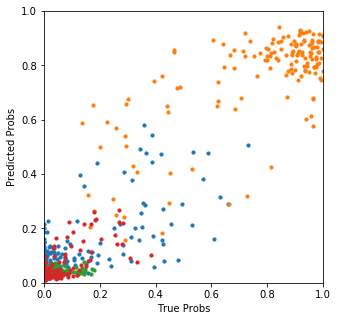

In [53]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1]);


# LR for mode choice

In [49]:
model = "GLM"

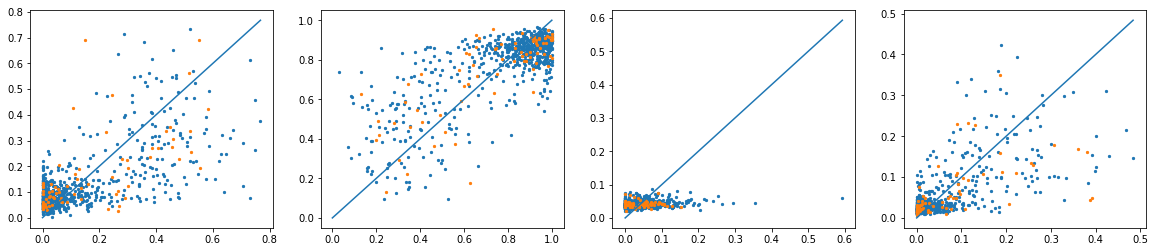

In [50]:
fig, ax = plt.subplots(1,4, figsize=(20,4))

pred_train = []
pred_test = []
train_mse_lr = []
train_r_lr = []
test_mse_lr = []
test_r_lr = []

for i in range(4):

    y_train_lr = y[~train_test_index,i]
    y_test_lr = y[train_test_index,i]

    if model == "LR":
    # Normal Linear Regression
        lr = linear_model.LinearRegression()
        lr.fit(x_train, y_train_lr)

    elif model == "GLM":
    # GLM with logit link (ensure probs are \in [0,1])
        lr = sm.GLM(y_train_lr, x_train, family=sm.families.Binomial())
        lr = lr.fit()
    else:
        print("ERROR")
        break
        
    ax[i].scatter(y_train_lr, lr.predict(x_train), s=5)
    ax[i].scatter(y_test_lr, lr.predict(x_test), s=5)
    ax[i].plot([0,max(y_train_lr)],[0, max(y_train_lr)])

    pred_train.append(lr.predict(x_train))
    pred_test.append(lr.predict(x_test)) 

    train_mse_lr.append(np.sqrt(mean_squared_error(lr.predict(x_train), y_train_lr)))
    train_r_lr.append(r2_score(y_train_lr, lr.predict(x_train)))
    test_mse_lr.append(np.sqrt(mean_squared_error(lr.predict(x_test), y_test_lr)))
    test_r_lr.append(r2_score(y_test_lr, lr.predict(x_test)))

pred_train = np.array(pred_train).T
pred_test = np.array(pred_test).T

In [51]:
train_mse = np.sqrt(mean_squared_error(pred_train, y[~train_test_index,:4]))
test_mse = np.sqrt(mean_squared_error(pred_test, y[train_test_index,:4]))

# the entropy function will normalize the probabilities
# not suitable for probabilities gotten from linear regression and GLM

# train_kl = entropy(y[~train_test_index,:4], pred_train, axis=1).mean()
# test_kl = entropy(y[train_test_index,:4], pred_test, axis=1).mean()

In [52]:
with open(out_dir+"BA_mode_choice.csv", "a") as f:
    f.write("%s,,,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % (model,
                      -1, train_mse, train_mse_lr[0], train_mse_lr[1], train_mse_lr[2], train_mse_lr[3],
                      -1, test_mse, test_mse_lr[0], test_mse_lr[1], test_mse_lr[2], test_mse_lr[3],
                      test_r_lr[0], test_r_lr[1], test_r_lr[2], test_r_lr[3])) 
                                                                                                      

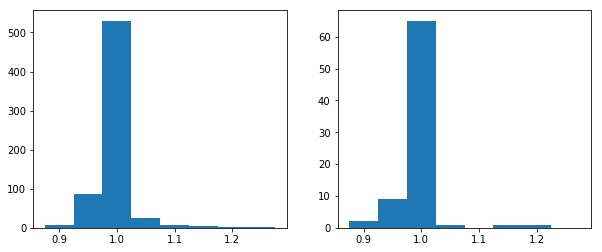

In [63]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(pred_train.sum(axis=1), bins = np.linspace(0.875, 1.275, 9))
ax[1].hist(pred_test.sum(axis=1), bins = np.linspace(0.875, 1.275, 9));

# LR for trip generation

In [65]:
trpgen_train = y[~train_test_index,-1]
trpgen_test = y[train_test_index,-1]

In [66]:
lr = linear_model.LinearRegression()
lr.fit(x_train, trpgen_train)
with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
    f.write("%.4f,%.4f,%.4f,%s,%d,%d\n" % (-1, 
        lr.score(x_train, trpgen_train), lr.score(x_test, trpgen_test), 'lr', 
        np.sum(lr.coef_ != 0), len(lr.coef_)))

In [67]:
for a in np.linspace(0.005, 0.014, 10):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
        f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
            lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
            np.sum(lasso.coef_ != 0), len(lasso.coef_)))

In [68]:
for a in np.linspace(1,4,10):
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
    with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
        f.write("%.4f,%.4f,%.4f,%s,%d,%d\n" % (a, 
            ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', 
            np.sum(ridge.coef_ != 0), len(ridge.coef_)))

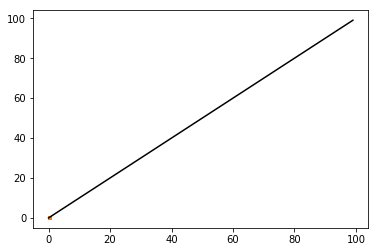

In [64]:
plt.scatter(trpgen_train, lr.predict(x_train), s=3)
plt.scatter(trpgen_test, lr.predict(x_test), s=3)
plt.plot(np.arange(100), np.arange(100), color='k');